**Importing Dependencies**

In [1]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow import keras
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense, BatchNormalization, GlobalAveragePooling2D
from tensorflow.keras.applications import VGG16
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.callbacks import EarlyStopping, LearningRateScheduler
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import zipfile
import os
from sklearn.model_selection import train_test_split
from PIL import Image
import warnings
warnings.filterwarnings("ignore")

ImportError: DLL load failed while importing _multiarray_umath: The specified module could not be found.

ImportError: DLL load failed while importing _multiarray_umath: The specified module could not be found.

ImportError: DLL load failed while importing _multiarray_umath: The specified module could not be found.

**Getting our Dataset**

In [2]:
file_path = 'archive_upd_bal.zip'

if zipfile.is_zipfile(file_path):
    print("Valid ZIP file.")
else:
    print("Invalid ZIP file or file is corrupted.")


Valid ZIP file.


In [3]:
import zipfile
zip_ref = zipfile.ZipFile('archive_upd_bal.zip','r')
zip_ref.extractall('/contents')
zip_ref.close ()

In [4]:
# Set directory path
data_dir = "/contents/archive_upd/archive/Indian-Traffic Sign-Dataset/Images"
# Sort class names numerically as labeling is in String form
classes = sorted(os.listdir(data_dir), key=lambda x: int(x))

# Collect all image paths and labels
image_paths = []
labels = []

for i, class_name in enumerate(classes):
    class_dir = os.path.join(data_dir, class_name)
    for img in os.listdir(class_dir):
        if img.lower().endswith(('.jpg', '.png', '.jpeg')):  # Ensure valid image files
            image_paths.append(os.path.join(class_dir, img))
            labels.append(i)  # Assign class index as integer

# Convert to numpy arrays
image_paths = np.array(image_paths)
labels = np.array(labels)

# Perform stratified split
train_paths, val_paths, train_labels, val_labels = train_test_split(
    image_paths, labels, test_size=0.2, stratify=labels, random_state=42
)

# Create datasets
def load_image(path, label):
    img = tf.io.read_file(path)
    img = tf.image.decode_png(img, channels=3)
    img = tf.image.resize(img, (64, 64)) / 255.0  # Normalize
    return img, label

train_ds = tf.data.Dataset.from_tensor_slices((train_paths, train_labels))
train_ds = train_ds.map(load_image).batch(16)
train_ds = train_ds.shuffle(buffer_size=len(train_paths))

val_ds = tf.data.Dataset.from_tensor_slices((val_paths, val_labels))
val_ds = val_ds.map(load_image).batch(16) 

In [5]:
print(len(image_paths))

10452


The dataset provided by KAGGLE is imbalanced

No of images for -

label 4 is 321.
label 7 is 601.
label 19 is 601.
label 43 is 144.
label 44 is 600.
label 45 is 220.
label 46 is 607.
label 47 is 602.
label 48 is 616.
label 49 is 200.
label 51 is 196.

I have already balanced the dataset. So using balanced dataset.

In [6]:
print(f"Number of training batches: {len(train_ds)}")
print(f"Number of validation batches: {len(val_ds)}")

Number of training batches: 523
Number of validation batches: 131


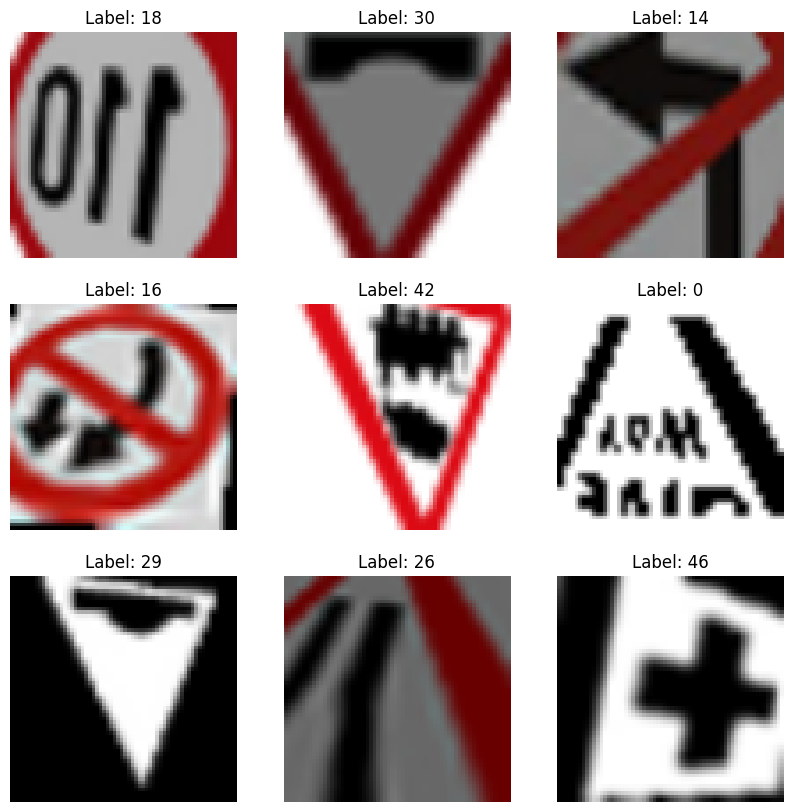

In [7]:
for images, labels in train_ds.take(1):  
    plt.figure(figsize=(10, 10))
    for i in range(9):  # Show 9 images
        plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy())
        plt.title(f"Label: {labels[i].numpy()}")
        plt.axis("off")
    plt.show()

Min pixel value: 0.0
Max pixel value: 1.0


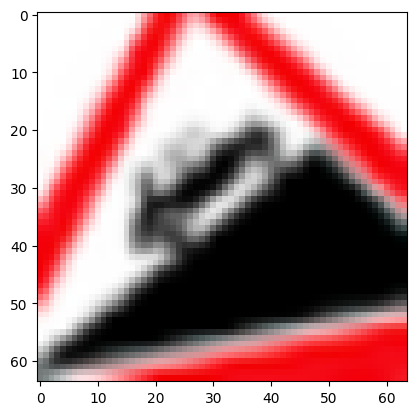

In [8]:
for image_batch, label_batch in train_ds.take(1):  # Get one batch of images
    image = image_batch[1].numpy()  # Take the first image of the batch
    print(f"Min pixel value: {np.min(image)}")
    print(f"Max pixel value: {np.max(image)}")
    
    # Plot the image to visually inspect it
    plt.imshow(image)
    plt.show()

**Model Building & Training**

In [37]:
model = Sequential()

model.add(Conv2D(32,kernel_size=(3,3),padding='same',activation='relu',input_shape=(64,64,3)))
model.add(BatchNormalization())
model.add(Conv2D(32,kernel_size=(3,3),padding='same',activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2),padding='same',strides=2)) 

model.add(Conv2D(64,kernel_size=(3,3),padding='same',activation='relu'))
model.add(BatchNormalization())
model.add(Conv2D(64,kernel_size=(3,3),padding='same',activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2),padding='same',strides=2)) 

model.add(Conv2D(128,kernel_size=(3,3),padding='same',activation='relu'))
model.add(BatchNormalization())
model.add(Conv2D(128,kernel_size=(3,3),padding='same',activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2),padding='same',strides=2))

model.add(Flatten())
model.add(Dense(256,activation='relu'))
model.add(Dropout(0.25))
model.add(Dense(128,activation='relu'))
model.add(Dropout(0.25))
model.add(Dense(52,activation='softmax'))

In [38]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 64, 64, 32)        896       
                                                                 
 batch_normalization_6 (Batc  (None, 64, 64, 32)       128       
 hNormalization)                                                 
                                                                 
 conv2d_7 (Conv2D)           (None, 64, 64, 32)        9248      
                                                                 
 batch_normalization_7 (Batc  (None, 64, 64, 32)       128       
 hNormalization)                                                 
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 32, 32, 32)       0         
 2D)                                                             
                                                      

In [39]:
from keras.utils import plot_model
plot_model(model,show_shapes=True)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


In [40]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),loss='sparse_categorical_crossentropy',metrics=['accuracy'])

In [41]:
history = model.fit(train_ds,epochs=20,batch_size=32,validation_data=val_ds)

Epoch 1/20


523/523 [==============================] - 11s 16ms/step - loss: 3.3569 - accuracy: 0.1630 - val_loss: 2.4476 - val_accuracy: 0.3673
Epoch 2/20
523/523 [==============================] - 10s 17ms/step - loss: 1.9698 - accuracy: 0.4547 - val_loss: 1.1803 - val_accuracy: 0.6729
Epoch 3/20
523/523 [==============================] - 10s 16ms/step - loss: 1.2959 - accuracy: 0.6188 - val_loss: 0.8107 - val_accuracy: 0.7666
Epoch 4/20
523/523 [==============================] - 10s 16ms/step - loss: 0.9303 - accuracy: 0.7238 - val_loss: 0.6719 - val_accuracy: 0.7991
Epoch 5/20
523/523 [==============================] - 10s 17ms/step - loss: 0.7156 - accuracy: 0.7814 - val_loss: 0.5556 - val_accuracy: 0.8264
Epoch 6/20
523/523 [==============================] - 12s 21ms/step - loss: 0.5447 - accuracy: 0.8349 - val_loss: 0.4769 - val_accuracy: 0.8575
Epoch 7/20
523/523 [==============================] - 16s 25ms/step - loss: 0.4671 - accuracy: 0.8568 - val_loss: 0.4721 - val_accuracy: 0.8532
Epo

**Visualization**

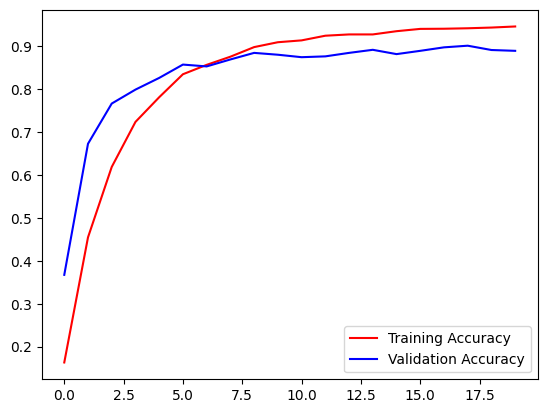

In [42]:
plt.plot(history.history['accuracy'],color='red',label='Training Accuracy')
plt.plot(history.history['val_accuracy'],color='blue',label='Validation Accuracy')
plt.legend()
plt.show()

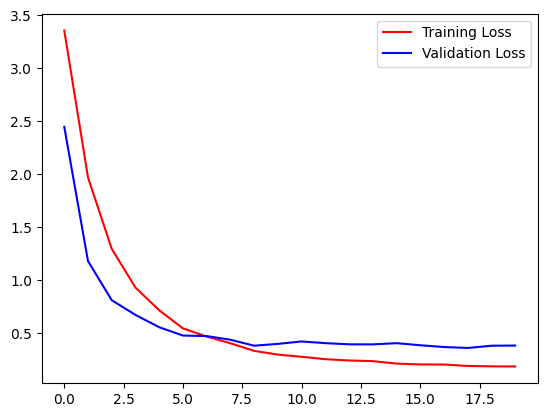

In [43]:
plt.plot(history.history['loss'],color='red',label='Training Loss')
plt.plot(history.history['val_loss'],color='blue',label='Validation Loss')
plt.legend()
plt.show()

**Testing**

In [50]:
model.save("traffic_sign_classifier.h5")
loaded_model_hs = tf.keras.models.load_model("traffic_sign_classifier.h5")

In [52]:
# Load and preprocess the image
def preprocess_image(image_path, target_size=(64, 64)):  
    img = Image.open(image_path).convert("RGB")  
    img = img.resize(target_size)  
    img_array = np.array(img) / 255.0  
    img_array = np.expand_dims(img_array, axis=0)
    return img_array

# Path to test image
image_path = "test2.png"  # Change to your image path

# Preprocess and predict
input_image = preprocess_image(image_path)

prediction = loaded_model_hs.predict(input_image)
softmax_probs = tf.nn.softmax(prediction)

# Get the predicted class -> Maximum Probability in softmax_probs
predicted_class = tf.argmax(softmax_probs,axis=-1).numpy()

print(f"Predicted Class: {predicted_class}")

sign = pd.read_csv("traffic_sign.csv")

sign_labels = list(sign['ClassId'].values)
sign_name = list(sign['Name'].values)

for i,label in enumerate(sign_labels):
    if label == predicted_class[0]:
        print(f"Sign is - {sign_name[i]}")

1/1 [==============================] - 1s 826ms/step
Predicted Class: [13]
Sign is - Length limit
